Config

In [3]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
    
import matplotlib.pyplot as plt

import os, warnings

from PIL import Image

Load Data

In [9]:
train_dir = 'C:/PythonProject/AI_Project/train_images'

In [10]:
batch_size = 16
img_dim = 128
RESCALE = 1.0/255

VALIDATION_SPLIT = 0.1
SEED = 42

warnings.filterwarnings("ignore") 

In [11]:
img_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=RESCALE,                   
    validation_split=VALIDATION_SPLIT,  
    rotation_range=5,                 
    shear_range=0.3,                   
    zoom_range=0.3,                    
    width_shift_range=0.05,            
    height_shift_range=0.05,            
    horizontal_flip=True,               
    vertical_flip=True,                 
)

In [12]:

ds_train = img_datagen.flow_from_directory(
    train_dir,
    subset="training",
    seed=SEED,
    shuffle=True,                   
    target_size=(img_dim, img_dim),  
    batch_size=batch_size,          
    class_mode="categorical",       
)

Found 9371 images belonging to 10 classes.


In [13]:

ds_valid = img_datagen.flow_from_directory(
    train_dir,
    subset="validation",
    seed=SEED,
    shuffle=False,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 1036 images belonging to 10 classes.


In [14]:
print(ds_train.class_indices)
OUTPUT_SIZE = len(ds_train.class_indices)

print("\n We have", OUTPUT_SIZE, " differents class")

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}

 We have 10  differents class


In [15]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=(img_dim, img_dim, 3)),
    layers.Conv2D(16, (3,3), activation='selu' ),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3,3), activation='selu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='selu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='selu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(2048, activation='selu'),
    layers.Dense(1024, activation='selu'),
    layers.Dense(256, activation='selu'),
    layers.Dense(128, activation='selu'),
    layers.Dense(OUTPUT_SIZE, activation='softmax')
])


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)       

In [16]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=5,  
                            verbose=0,   
                            mode='auto') 

lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                            factor=0.7,
                            patience=5) 

callbacks = [early_stopping_callback, lr_reducer]

In [17]:
EPOCHS = 15


with tf.device(tf.test.gpu_device_name()):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=135e-6), 
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.Accuracy()]
    )
    
    history = model.fit(
        ds_train,
        epochs = EPOCHS,
        validation_data = ds_valid,
        callbacks = callbacks,
        verbose = 1,
    )

Epoch 1/15

586/586 [==============================] - 1039s 2s/step - loss: 2.0611 - accuracy: 0.0000e+00 - val_loss: 1.7364 - val_accuracy: 0.0000e+00 - lr: 1.3500e-04
Epoch 2/15
586/586 [==============================] - 134s 229ms/step - loss: 1.7050 - accuracy: 0.0000e+00 - val_loss: 1.7692 - val_accuracy: 0.0000e+00 - lr: 1.3500e-04
Epoch 3/15
586/586 [==============================] - 110s 188ms/step - loss: 1.5309 - accuracy: 0.0000e+00 - val_loss: 1.3846 - val_accuracy: 0.0000e+00 - lr: 1.3500e-04
Epoch 4/15
586/586 [==============================] - 105s 178ms/step - loss: 1.3565 - accuracy: 0.0000e+00 - val_loss: 1.3481 - val_accuracy: 0.0000e+00 - lr: 1.3500e-04
Epoch 5/15
586/586 [==============================] - 118s 201ms/step - loss: 1.2575 - accuracy: 0.0000e+00 - val_loss: 1.2135 - val_accuracy: 0.0000e+00 - lr: 1.3500e-04
Epoch 6/15
586/586 [==============================] - 112s 191ms/step - loss: 1.1608 - accuracy: 0.0000e+00 - val_loss: 1.1979 - val_accuracy: 0.0

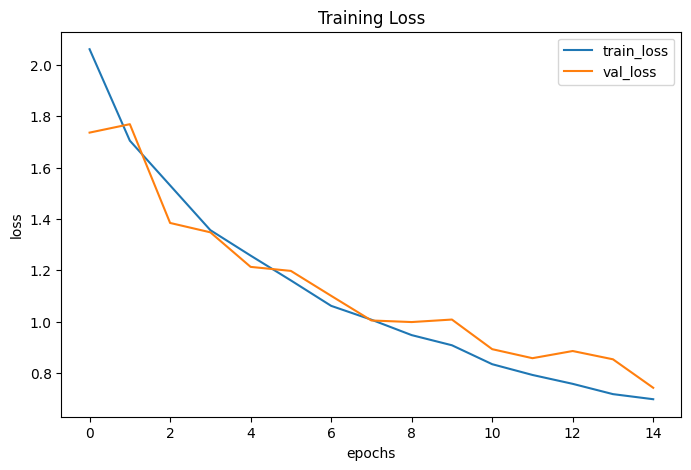

In [18]:


plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])


Test Predictions

In [19]:

test_path = 'C:/PythonProject/AI_Project/test_images'
ds_test = keras.preprocessing.image.ImageDataGenerator(rescale=RESCALE).flow_from_directory(    
    directory=test_path,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    classes=['.'],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [20]:

predict = model.predict(ds_test, verbose=1)

217/217 [==============================] - 34s 157ms/step


In [21]:
predicted_class_indices = np.argmax(predict,axis=1)
print(set(predicted_class_indices))

inv_map = {v:k for k,v in ds_train.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Submission

In [22]:
filenames = ds_test.filenames

submission = pd.DataFrame({ "image_id":filenames, "label":predictions })

submission.image_id = submission.image_id.str.replace('./', '')
submission.to_csv("submission.csv",index=False)
submission.head()

,image_id,label
0,.\200001.jpg,hispa
1,.\200002.jpg,hispa
2,.\200003.jpg,blast
3,.\200004.jpg,blast
4,.\200005.jpg,blast


In [23]:
submission['label'].value_counts()

label
normal                      662
blast                       623
dead_heart                  573
hispa                       501
tungro                      304
brown_spot                  211
bacterial_leaf_streak       209
bacterial_leaf_blight       154
downy_mildew                141
bacterial_panicle_blight     91
Name: count, dtype: int64

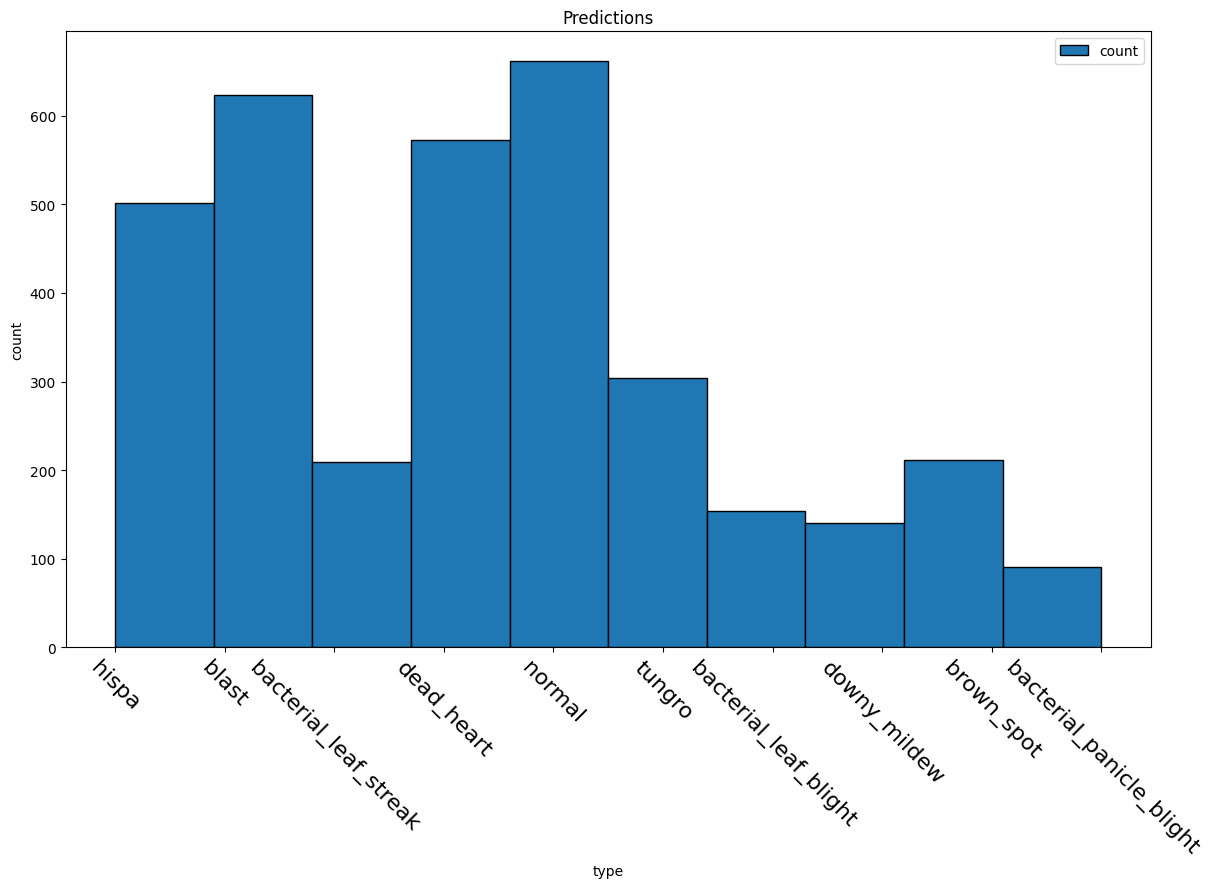

In [24]:
plt.figure(figsize=(14, 8))

plt.hist(submission['label'], edgecolor = 'black')
plt.xticks(rotation = -45, fontsize=16)
plt.title('Predictions')
plt.xlabel('type')
plt.ylabel('count')
plt.legend(['count'])


In [25]:
from tensorflow.keras.models import load_model

model.save('C:/PythonProject/AI_Project/Model.h5')